## Step 4: Statistical SLA Calibration

This notebook performs **statistical calibration of SLA thresholds** using historical worker performance.  
The goal is to balance **fairness and client expectations** by setting **data-driven SLA thresholds** for accuracy and task count.

We will:
1. Analyze historical performance distributions.
2. Set percentile-based SLA thresholds.
3. Evaluate compliance with these calibrated SLAs.
4. Compare with fixed client SLAs.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load previous dataset
df = pd.read_csv("simulated_worker_tasks.csv", parse_dates=["task_date"])
df.head()

,task_id,worker_id,task_date,task_complexity,time_taken_minutes,accuracy
0,77016b53-3aa3-497a-b042-4246e5a9583e,W_001,2024-01-01,Low,5.28,0.990
1,7f65a185-9675-4d6d-974c-c0b27805270a,W_001,2024-01-01,Medium,7.30,0.946
2,a78aa64d-4a37-4105-baab-125b5d293c4e,W_001,2024-01-01,Low,4.43,0.952
3,2d08d6c7-c351-40f4-af67-5a62f3a250ce,W_001,2024-01-01,Medium,5.41,0.913
4,c236a814-63f0-4035-8e30-b4642282a1d8,W_001,2024-01-01,Medium,7.36,0.908


## Aggregate Worker Performance

- Compute **average accuracy** and **total tasks** per worker per day.
- These metrics will be used to define **data-driven SLA thresholds**.

In [2]:
# Daily stats per worker
daily_stats = df.groupby(['worker_id', 'task_date']).agg(
    tasks_completed=('task_id','count'),
    avg_accuracy=('accuracy','mean')
).reset_index()

daily_stats.head()

,worker_id,task_date,tasks_completed,avg_accuracy
0,W_001,2024-01-01,18,0.955167
1,W_001,2024-01-02,17,0.941176
2,W_001,2024-01-03,13,0.932769
3,W_001,2024-01-04,12,0.945667
4,W_001,2024-01-05,21,0.934905


## Statistical SLA Thresholds

- Use historical percentiles to define **calibrated SLA**:
  - Accuracy SLA → 75th percentile of average accuracy
  - Task Count SLA → 70th percentile of daily task count

- Percentile thresholds ensure **most workers can realistically meet SLA**, while still maintaining high standards.

In [3]:
# Accuracy threshold
accuracy_sla_calibrated = daily_stats['avg_accuracy'].quantile(0.75)
# Task count threshold
task_count_sla_calibrated = daily_stats['tasks_completed'].quantile(0.70)

print(f"Calibrated Accuracy SLA: {accuracy_sla_calibrated:.2f}")
print(f"Calibrated Task Count SLA: {task_count_sla_calibrated:.0f}")

Calibrated Accuracy SLA: 0.95
Calibrated Task Count SLA: 17


## Evaluate SLA Compliance with Calibrated Thresholds

- Determine how many workers meet the **calibrated SLAs** daily.
- Compare compliance rates with **fixed client SLAs**.

In [4]:
# Evaluate compliance
daily_stats['accuracy_sla_met_calibrated'] = daily_stats['avg_accuracy'] >= accuracy_sla_calibrated
daily_stats['task_count_sla_met_calibrated'] = daily_stats['tasks_completed'] >= task_count_sla_calibrated
daily_stats['overall_sla_met_calibrated'] = daily_stats['accuracy_sla_met_calibrated'] & daily_stats['task_count_sla_met_calibrated']

# Summarize compliance per worker
sla_summary_calibrated = daily_stats.groupby('worker_id').agg(
    total_days=('task_date','nunique'),
    days_accuracy_sla_met=('accuracy_sla_met_calibrated','sum'),
    days_task_sla_met=('task_count_sla_met_calibrated','sum'),
    days_overall_sla_met=('overall_sla_met_calibrated','sum')
).reset_index()

sla_summary_calibrated['accuracy_sla_pct'] = (sla_summary_calibrated['days_accuracy_sla_met']/sla_summary_calibrated['total_days']*100).round(2)
sla_summary_calibrated['task_sla_pct'] = (sla_summary_calibrated['days_task_sla_met']/sla_summary_calibrated['total_days']*100).round(2)
sla_summary_calibrated['overall_sla_pct'] = (sla_summary_calibrated['days_overall_sla_met']/sla_summary_calibrated['total_days']*100).round(2)

sla_summary_calibrated.head()

,worker_id,total_days,days_accuracy_sla_met,days_task_sla_met,days_overall_sla_met,accuracy_sla_pct,task_sla_pct,overall_sla_pct
0,W_001,30,6,11,3,20.00,36.67,10.00
1,W_002,30,7,13,2,23.33,43.33,6.67
2,W_003,30,9,8,3,30.00,26.67,10.00
3,W_004,30,6,13,2,20.00,43.33,6.67
4,W_005,30,7,8,0,23.33,26.67,0.00


## Compare Compliance: Fixed vs Calibrated SLA

- Visualize the **effect of statistical calibration**.
- Calibrated SLAs should **increase fairness**, allowing workers to realistically meet thresholds.

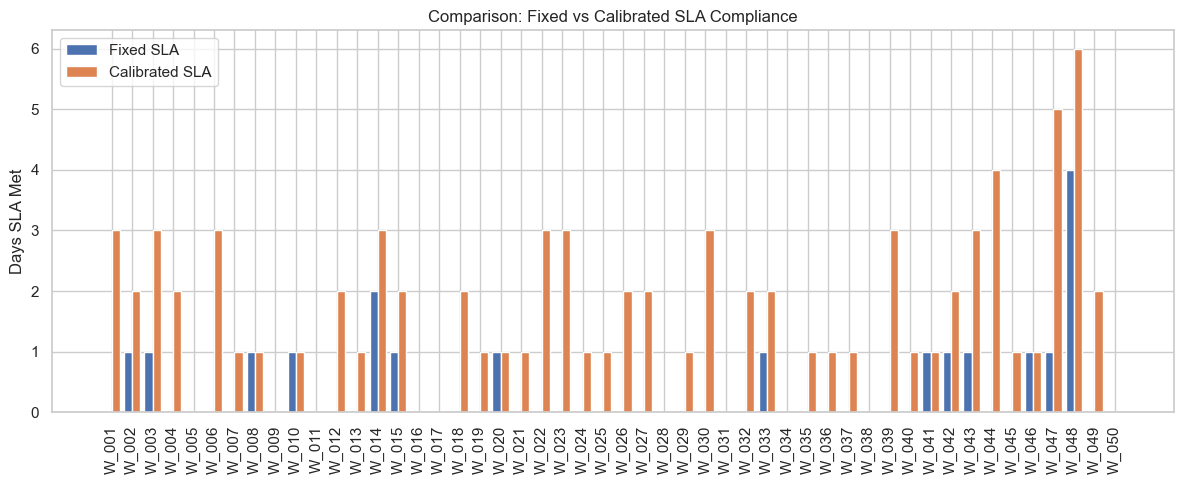

In [5]:
# Merge fixed SLA summary
daily_stats_fixed = df.groupby(['worker_id', 'task_date']).agg(
    tasks_completed=('task_id','count'),
    avg_accuracy=('accuracy','mean')
).reset_index()
daily_stats_fixed['accuracy_sla_met'] = daily_stats_fixed['avg_accuracy'] >= 0.95
daily_stats_fixed['task_count_sla_met'] = daily_stats_fixed['tasks_completed'] >= 20
daily_stats_fixed['overall_sla_met'] = daily_stats_fixed['accuracy_sla_met'] & daily_stats_fixed['task_count_sla_met']

sla_summary_fixed = daily_stats_fixed.groupby('worker_id').agg(
    days_accuracy_sla_met=('accuracy_sla_met','sum'),
    days_task_sla_met=('task_count_sla_met','sum'),
    days_overall_sla_met=('overall_sla_met','sum')
).reset_index()

# Plot comparison
plt.figure(figsize=(12,5))
x = np.arange(len(sla_summary_fixed['worker_id']))
plt.bar(x - 0.2, sla_summary_fixed['days_overall_sla_met'], width=0.4, label='Fixed SLA')
plt.bar(x + 0.2, sla_summary_calibrated['days_overall_sla_met'], width=0.4, label='Calibrated SLA')
plt.xticks(x, sla_summary_fixed['worker_id'], rotation=90)
plt.ylabel("Days SLA Met")
plt.title("Comparison: Fixed vs Calibrated SLA Compliance")
plt.legend()
plt.tight_layout()
plt.show()

## Key Observations

1. **Calibrated SLAs** increase the number of workers meeting SLA, especially those struggling under fixed thresholds.  
2. Maintains **high standards** while ensuring fairness based on **historical performance**.  
3. Prepares the dataset for **learning curve analysis**, **Pareto principle evaluation**, and **performance segmentation** in subsequent steps.